# Imports

In [1]:
%%capture
import os
import shutil
import pickle

import re
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import multiprocessing as mp
from pathlib import Path

import sys
sys.path.append('/n/groups/patel/JbProst/Heart/')
from DataFunctions import *
from EvaluatingFunctions import *
from PlottingFunctions import *
from EvaluatingModels import R2Callback, resume_training, save_print_lr
from tqdm import tqdm

# Training score

In [265]:
channel = 4
dir_ = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}ch/'.format(channel)
df_scores, df_losses  = retrieve_score(dir_)

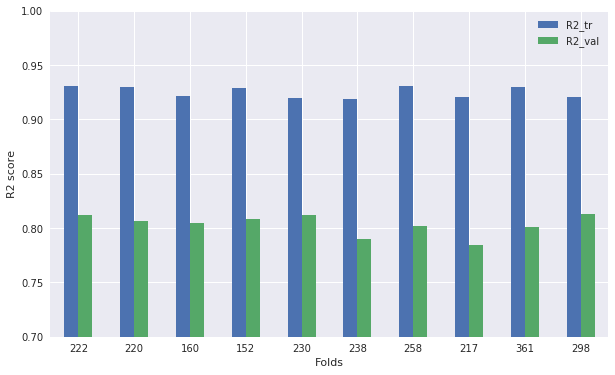

In [266]:
nb_iter= []
for folder in sorted([fol for fol in os.listdir(dir_) if fol.startswith('Fold')]):
    nb_iter.append(str(len(pd.read_csv('/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}ch/{}/score.csv'.format(channel,folder)))))
    
plt.style.use('seaborn')
df_scores.max().unstack().loc[['R2_tr', 'R2_val'],['Fold{}'.format(i) for i in range(10)]].transpose().plot.bar(figsize=(10,6))
plt.xlabel('Folds')
plt.ylabel('R2 score')
plt.xticks(range(10),labels=nb_iter, rotation='horizontal')
plt.ylim([0.7, 1])
plt.show()

display(df_scores['R2_val'].max())

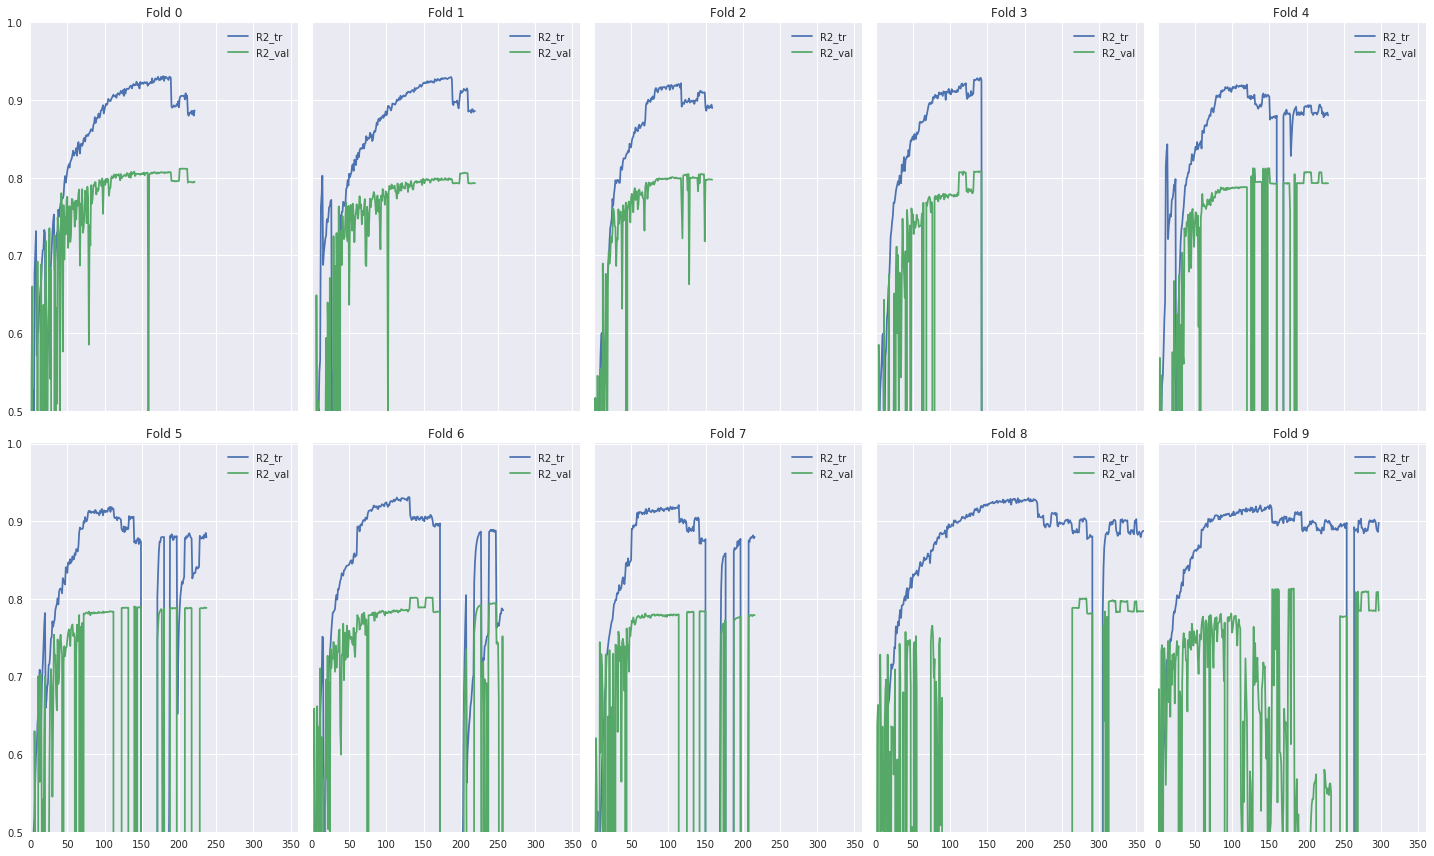

In [267]:
fig, axes= plt.subplots(2,5,figsize=(20,12), sharex=True, sharey=True)
axes = axes.flatten()
axes[0].set_ylim([0.5,1])
for i in range(10):
    df_scores.swaplevel(axis=1).stack().unstack()['Fold{}'.format(i)][['R2_tr', 'R2_val']].plot(ax=axes[i], title='Fold {}'.format(i))
fig.tight_layout()

# Get predictions

To get the predictions, run the following script :
    `/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/Call_predictions.sh`

In [293]:
# ! /n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/Call_predictions.sh

#### Manage saved models/weights

Removes weights files tha are not used to yield predictions or thaat are not the last three of the training session

In [292]:
for channel in [3,4]:
    for kfold in range(10):
        to_keep = []
        dir_ = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}ch/Fold{}/'.format(channel, kfold)
        df_scores, _  = retrieve_score(dir_)
        
        weights_files = [(dir_ + w) for w in os.listdir(dir_) if w.endswith('.h5')]
        
        # models weights/files to keep
        weights_nb = [int(w.split('_')[-1].split('.')[0]) for w in weights_files]
        epoch_best_val = int(df_scores['R2_val'].loc[weights_nb].argmax())
        epoch_best_tr = int(df_scores['R2_tr'].loc[weights_nb].argmax())
        
        # files to keep
        to_keep.append(epoch_best_tr)
        to_keep.append(epoch_best_val)
        
        # keep the last three weights by date of creation
        last_3 = sorted(weights_files, key=os.path.getmtime, reverse=True)[:3]
        to_keep += [int(w.split('_')[-1].split('.')[0]) for w in last_3]
        
        for epoch in set(to_keep):
            #file to keep are kept to the list of weights files
            weights_files.remove(dir_ + 'epoch_{:04.0f}.h5'.format(epoch))

        #removing
        for wf in weights_files:
            os.remove(wf)

#### Get R$^2$ score

In [255]:
cols= pd.MultiIndex.from_product([['3ch', '4ch'], ['Train', 'Test', 'Val']])
df_scores = pd.DataFrame(index=['Fold'+str(i) for i in range(10)],
                 columns=cols)
df_predictions = pd.DataFrame()
for channel in ['3ch','4ch']:
    for kfold in range(10):
        for part in ['train','test','val']:
            try:
                dir_csv = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}/Fold{}/{}predictions_augmented.csv'.format(channel,
                                                                                                                  kfold,
                                                                                                                 part.lower())
                #load predictions
                df_tmp = pd.read_csv(dir_csv, index_col='eid')
                
                df_tmp['chambers'] = channel
                df_tmp['instance'] = instance
                df_tmp['fold'] = kfold
                df_tmp['partition'] = part
                
                #compute the residual
                df_tmp['res'] = abs(df_tmp.Age_raw - df_tmp.Pred )
                #gather predictions
                df_predictions = pd.concat((df_predictions, df_tmp))

                #compute R2 score
                r2_tmp = r2_score(df_tmp.Age_raw,df_tmp.Pred )
                df_scores.loc['Fold'+str(kfold), (channel, part.capitalize())]= r2_tmp

            except FileNotFoundError:
                print('/{}/Fold{}/{}predictions_augmented.csv is MISSING'.format(channel, 
                                                                                 kfold,
                                                                                 part.lower())
                pass

In [254]:
df_scores

3ch                           4ch                    
          Train      Test       Val     Train      Test       Val
Fold0  0.968187  0.814034  0.809832  0.960787  0.789565  0.793954
Fold1   0.96959  0.809918  0.808116  0.958372  0.792869  0.792386
Fold2  0.963472   0.80278  0.806403  0.965615  0.785791  0.799302
Fold3  0.979877  0.812199  0.807088  0.971338  0.789639  0.783849
Fold4  0.962477  0.809401   0.81324  0.963135  0.788372  0.794717
Fold5  0.965232  0.807045  0.809701   0.96218  0.787995   0.79039
Fold6  0.964017  0.805456  0.802974  0.968014  0.785625  0.789616
Fold7  0.970676  0.797046  0.786231  0.963566  0.798832  0.784945
Fold8  0.970173  0.812005  0.802884  0.959548  0.786659   0.79049
Fold9  0.966005  0.809156  0.811652  0.972572   0.79147  0.788992

### Bad quality samples

5 samples to inspect


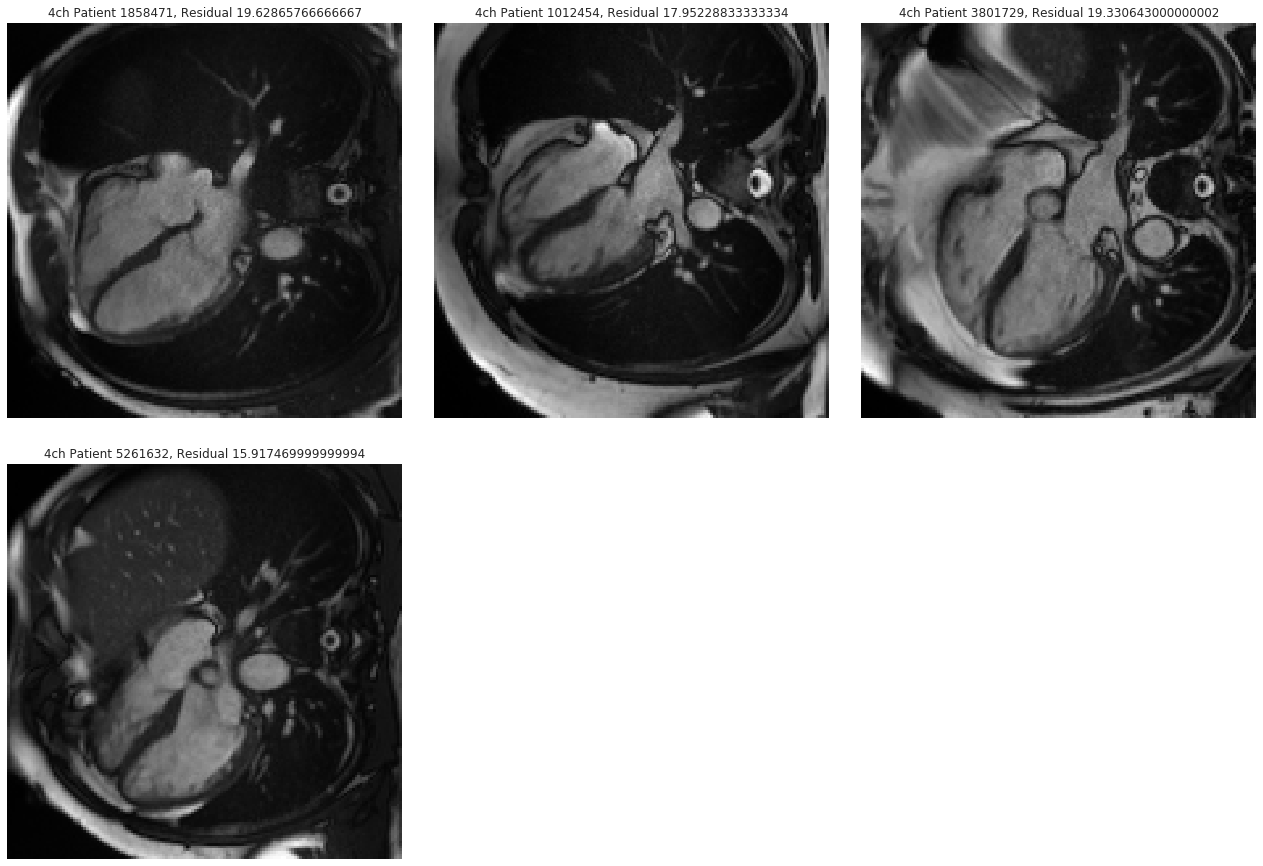

In [300]:
channel = '4ch'
df_plot = df_predictions[df_predictions.chambers == channel].sort_values(by = 'res', ascending= False)

# residuals threshold to inspect the images
threshold = 15
# work only on the training predictions
df_plot = df_plot[(df_plot.res >= threshold) & (df_plot.partition== 'train')] 

nb_plots = len(set(df_plot.index))
print(str(nb_plots) + ' samples to inspect')

# displays bad images
if nb_plots !=0 :
    im_dir = '/n/scratch3/users/j/jp379/shape25x150x150-{}_Augmented/{}.npy'
    im_dir_corrupted = '/n/scratch3/users/j/jp379/CorruptedSamples/{}/{}.npy'
    
    fig, axes = plt.subplots(int(np.ceil(nb_plots/3)), 3, figsize=(18,2.5*nb_plots))
    axes = axes.flatten()
    for ax in axes :
         ax.set_visible(False)
    ax =0
    
    to_move = [] # to move in the CorruptedSamples directory
    for patient in df_plot.index.unique():
        try :
            try :
                im = np.load(im_dir.format(channel, patient))[0,:,:]
            except FileNotFoundError:
                im = np.load(im_dir.format(channel, str(patient)+'3'))[0,:,:]

            res = df_plot.loc[patient].res.mean()
            axes[ax].set_visible(True)
            axes[ax].imshow(im, cmap='gray')
            axes[ax].set_title(channel+' Patient ' + str(patient)+', Residual '+str(res))
            axes[ax].axis('off')
            ax +=1 
        except FileNotFoundError:
            try:
                im = np.load(im_dir_corrupted.format(channel, patient))[0,:,:]
                res = df_plot.loc[patient].res.mean()
                axes[ax].set_visible(True)
                axes[ax].imshow(im, cmap='gray')
                axes[ax].set_title(channel +' ' + str(patient)+' DISCARDED')
                axes[ax].axis('off')
                ax +=1 
            except FileNotFoundError:
                to_move.append(patient)
    fig.tight_layout()
    fig.show()
else :
    print('All samples have already been inspected and moved to the ~/CorruptedSamples'
         ' directory')

In [28]:
im_dir = '/n/scratch3/users/j/jp379/shape25x150x150-{}_Augmented/{}.npy'
remove= dict() # hand picked samples to remove when trheshold is 10 < t <20
remove['3ch'] = ['3480190','3962461','2386202','5970635','2130423','2380202','2441151',
              '3110739','2441151','4978787','2477221', '3880091', '2299781', '2489250',
                '4812074','4213768', '1129551', '3817043', '4409861', '4302854',
                '1674312', '1369782', '4656476', '2766491', '5008586', '3367963',
                '1802108', '3745871','4173061','5123167','3559924','3745871', '4022431',
                '5449006']

remove['4ch'] = ['4442747','1633374','1077517','2486338','1621110','1271207','3110739',
              '1271207', '4062785','1906866','3794939', '2823106','2745704','1822862',
                '2489250', '3745871', '2848541', '2871881', '2486388', '4710734', 
                 '3082947', '1477501','2920125','1254385', '1254385','4022431']

for channel in ['3ch','4ch']:
    for patient in remove[channel]:
        try :
            os.remove(im_dir.format(channel, patient))
        except FileNotFoundError:
            pass

# Delete samples that are corrupted on the dataframe 'removed_samples' (when the
# residucal threshold is set high -  threshold > 50 - after inspection)
for channel in ['3ch','4ch']:
    for patient in removed_samples.index:
        try :
            os.remove(im_dir.format(channel, patient))
        except FileNotFoundError:
            pass

In [8]:
# move files that have been removed from the Augmented (i.e. the training folder)
# to a dedicated folder of Corrupted files.
for channel in ['4ch', '3ch']:
    im_dir = '/n/scratch3/users/j/jp379/shape25x150x150-{}_Augmented/'
    instance_2 = '/n/scratch3/users/j/jp379/shape25x150x150-{}_2/'.format(channel)
    instance_2_2 = '/n/scratch3/users/j/jp379/shape25x150x150-{}_2_2/'.format(channel)
    instance_3 = '/n/scratch3/users/j/jp379/shape25x150x150-{}_3/'.format(channel)

    augmented = os.listdir(im_dir.format(channel))
    non_filtered_Ch = os.listdir(instance_2)
    non_filtered_Ch += os.listdir(instance_2_2)
    non_filtered_Ch += os.listdir(instance_3)
    bad_im = set(non_filtered_Ch) - set(augmented) 

    for sample in bad_im:
        if sample in os.listdir(instance_3):
            shutil.copyfile(instance_3 + sample , '/n/scratch3/users/j/jp379/CorruptedSamples/{}/'.format(channel)+ sample)
        elif sample in os.listdir(instance_2_2):
            shutil.copyfile(instance_2_2 + sample , '/n/scratch3/users/j/jp379/CorruptedSamples/{}/'.format(channel)+ sample)
        else:
            shutil.copyfile(instance_2 + sample , '/n/scratch3/users/j/jp379/CorruptedSamples/{}/'.format(channel)+ sample)

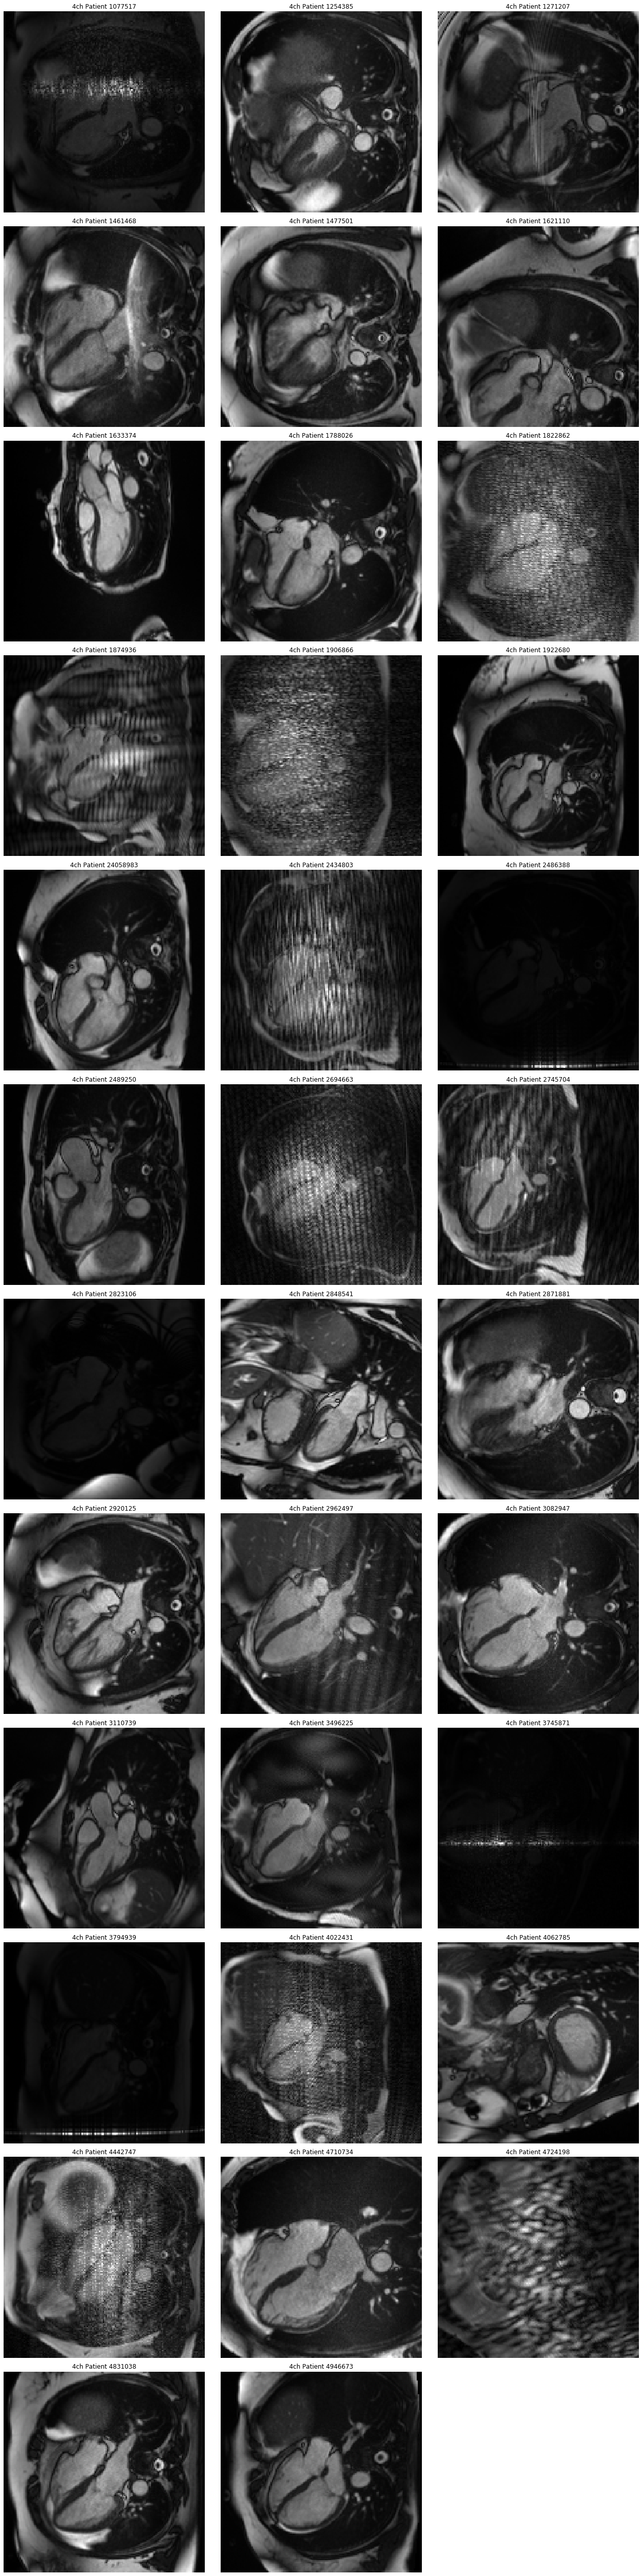

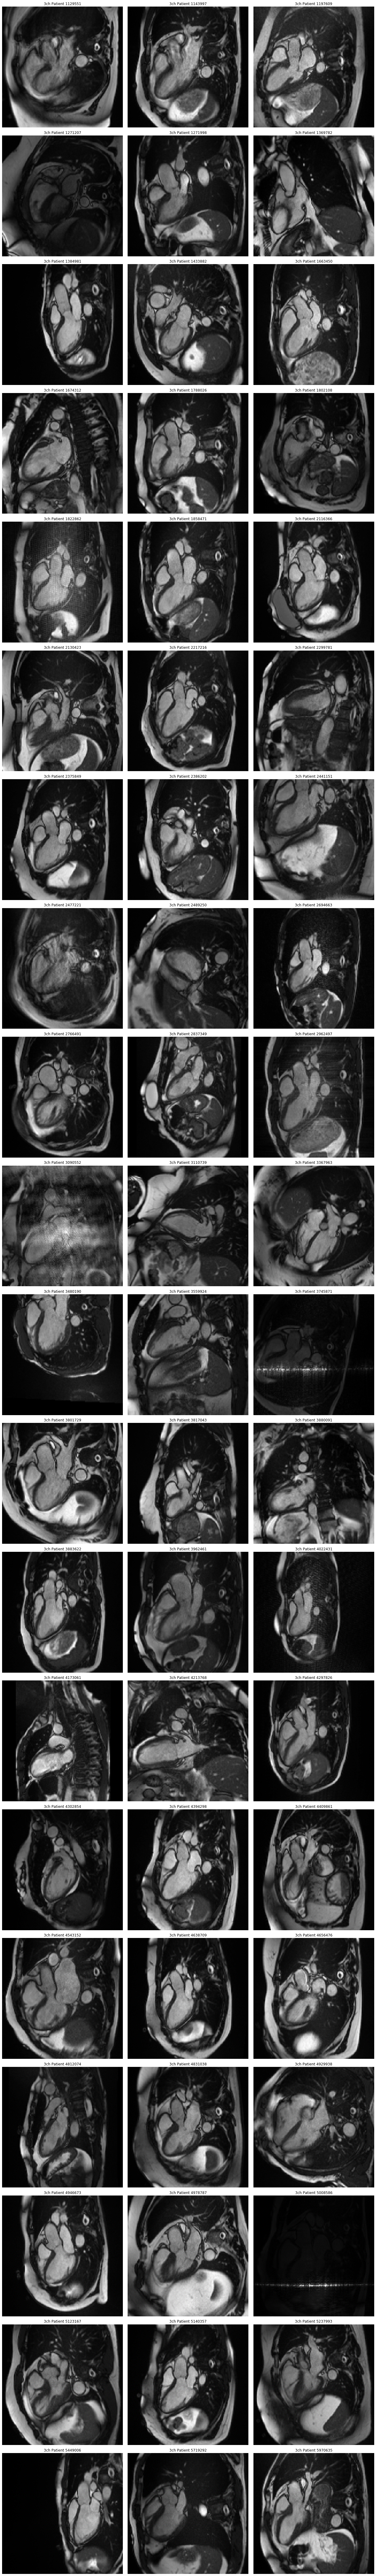

In [245]:
for channel in ['4ch', '3ch']:
    bad_im_dir = '/n/scratch3/users/j/jp379/CorruptedSamples/{}/'.format(channel)
    bad_im = os.listdir(bad_im_dir)
    nb_plots = len(bad_im)

    fig, axes = plt.subplots(int(np.ceil(nb_plots/3)), 3, figsize=(18,2*nb_plots))
    axes = axes.flatten()
    for ax in axes :
         ax.set_visible(False)
    ax =0
    for sample in bad_im:
        im = np.load(bad_im_dir+sample)[0,:,:]
        axes[ax].set_visible(True)
        axes[ax].imshow(im, cmap='gray')
        axes[ax].set_title(channel+' Patient {}'.format(sample.strip('.npy')))
        axes[ax].axis('off')
        axes[ax].set_facecolor('white')

        ax +=1 

    
    fig.tight_layout()
    fig.show()

### Get rid of bad samples in the predictions

In [2]:
im_dir_corrupted = '/n/scratch3/users/j/jp379/CorruptedSamples/{}/'
for channel in ['3ch','4ch']:
    corrupted_files = [int(x.strip('.npy')) for x in os.listdir(im_dir_corrupted.format(channel))]
    for part in ['train','test','val']:
        df_predictions = pd.DataFrame() 
        for kfold in range(10):
            dir_csv = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}/Fold{}/{}predictions_augmented.csv'.format(channel,
                                                                                                              kfold,
                                                                                                             part.lower())
            df_tmp = pd.read_csv(dir_csv, index_col='eid')

            # removes the line that have an eid with bad/corrupted image 
            corrupted_samples = df_tmp.index.isin(corrupted_files)
            df_tmp[~corrupted_samples].to_csv('/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}/Fold{}/{}predictions_augmented'.format(channel,
                                                                                                              kfold,
                                                                                                             part.lower()))
            df_tmp['outer_fold'] = int(kfold)
            df_predictions = pd.concat((df_predictions, df_tmp[~corrupted_samples]))

        # save a file for every partition
        df_predictions.to_csv('/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/Predictions_{}_{}.csv'.format(part, channel))

### Formating predictions

The predictions are gathered and saved into a csv file with specific formating : 
 - id : _eid\_instance_
 - pred : the prediction
 - outer_fold : the outer fold of the list of patients

In [5]:
def get_instance():
    """
    Get the instance of every sampleReturns a pd.Series with column
    `eid_InstanceNumber`
    """
    df = pd.read_csv('/n/groups/patel/JbProst/Heart/Data/id_instance_outer_fold.p', index_col = 'eid')
    return df.drop(columns=['instance', 'outer_fold'])

In [7]:
# directory and file name
path = '/n/groups/patel/Alan/Aging/Medical_Images/data_predictions_videos/'
file_name = 'Predictions_instances_Age_Heart_MRI_{}chambersRaw_3DCNN_2_1024_Adam_0.0001_0.0_0.2_1.0_{}.csv'

for channel in ['4ch', '3ch']:
    instances = get_instance(channel) # get the instance of every eid
    for part in ['train','test','val']:
        df_predictions = pd.DataFrame() 
        for kfold in range(10):
            dir_csv = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}/Fold{}/{}predictions_augmented.csv'.format(channel,
                                                                                                              kfold,
                                                                                                             part.lower())
            #load predictions
            df_tmp = pd.read_csv(dir_csv, index_col='eid')
            #formating
            df_tmp.rename(columns = {'Pred': 'pred'}, inplace = True)
            df_tmp.drop(columns=['Age_raw'], inplace = True)
            df_tmp['outer_fold'] = kfold

            #add the instance info and correct formating
            df_tmp = df_tmp.join(instances)
            df_predictions = pd.concat((df_predictions, df_tmp))
            # reordering of the columns
            df_predictions = df_predictions[['id', 'pred', 'outer_fold']]

        # save a file for every partition
        df_predictions.to_csv(path + file_name.format(channel[0], part), index = False)

df_predictions.head() # example of output

/home/jp379/TFGPU/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



id       pred  outer_fold
eid                                      
1000595  1000595_2  70.918550           0
1000697  1000697_2  69.795900           0
1001687  1001687_2  72.567360           0
1004387  1004387_2  56.835900           0
1004475  1004475_2  74.939156           0

##### Ensemble model

In [28]:
path = '/n/groups/patel/Alan/Aging/Medical_Images/data_predictions_videos/'
file_name = 'Predictions_instances_Age_Heart_MRI_34chambersRawVideo_3DCNN_2_1024_Adam_0.0001_0.0_0.2_1.0_{}.csv'

# get the instance of each samples. Some have been discarded in chambers folders 
instances = get_instance('3ch')
instances = pd.concat((instances, get_instance('4ch')), axis=0).drop_duplicates()
for part in ['train','test','val']:
    df_predictions = pd.DataFrame()
    for kfold in range(10):
        # 4 chambers
        dir_csv = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}/Fold{}/{}predictions_augmented.csv'.format('4ch',
                                                                                                          kfold,
                                                                                                         part.lower())
        df_tmp = pd.read_csv(dir_csv, index_col='eid', usecols= ['eid','Pred'])
        # 3 chambers
        dir_csv = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}/Fold{}/{}predictions_augmented.csv'.format('3ch',
                                                                                                          kfold,
                                                                                                         part.lower())
        # join both predictions
        df_tmp = df_tmp.join(pd.read_csv(dir_csv, index_col='eid', 
                                         usecols= ['eid','Pred']),
                             rsuffix = '3ch')
        
        df_tmp.dropna(inplace=True) # drop patient not present in both views
        df_tmp['pred'] = df_tmp.mean(axis=1) # ensemble model 
        df_tmp['outer_fold'] = kfold

        #add the instance info and correct formating
        df_tmp = df_tmp.join(instances)
        df_predictions = pd.concat((df_predictions, df_tmp))
        df_predictions.dropna(inplace = True)

        # reordering of the columns
        df_predictions = df_predictions[['id', 'pred', 'outer_fold']]
    
    # save a file for every partition
    df_predictions.to_csv(path + file_name.format(part), index = False)

/home/jp379/TFGPU/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [31]:
df_predictions.head()

id       pred  outer_fold
0  1000595_2  71.336133           0
1  1000697_2  69.080850           0
2  1001687_2  74.193093           0
3  1004387_2  56.629887           0
4  1004475_2  74.062743           0

# Add instance 2_2 and 3

### Second Second  and Thrid instance

In [65]:
import copy
def kfold_updating(new_dir, instance = '', old_dir= None, partition=False, 
                   append_to_partition=False,
                  append_to_test_only = False):
    
    new_instance = [int(file.split('.')[0]) for file in os.listdir(new_dir)]
    partitioning_new = []
    
    #Empty dict of dicts of lists
    partitioning = dict.fromkeys(range(10))
    for key in partitioning.keys():
        partitioning[key] = {'val':[], 'test':[], 'train' : []}
    partitioning_new = partitioning.copy()
    
    #### Samples to reassigned (two samples for patients) <=> new sample for known patient
    if partition: #if a old parition is given
        old_instance_ids = []
        for kfold in range(10):
            old_instance_ids += partition[kfold]['val']
            old_instance_ids += partition[kfold]['train']
            old_instance_ids += partition[kfold]['test']
        old_instance = copy.deepcopy(partition)
    else: # if a directory is given
        old_instance_ids = [int(file.split('.')[0]) for file in os.listdir(old_dir)]

    # Samples presents in the old partition
    to_reassign = list(set(new_instance) - (set(new_instance) - set(old_instance_ids)))
    print('{}/{} samples are repetition from participants'.format(len(to_reassign),len(new_instance)))
    csv_dir = '/n/groups/patel/Alan/Aging/Medical_Images/data2/data-features_Heart_20208_Age_{}_{}.csv'

    if len(to_reassign)>0:
        for kfold in range(10):
            if not partition:
                partition_tmp, _ = get_data_fold(kfold, csv_dir, target = 'Age_raw')
            else:
                partition_tmp = copy.deepcopy(old_instance[kfold])
                
            # ids to reassign per paritition
            val =  list(set(to_reassign) - (set(to_reassign) - set(partition_tmp['val'])))
            test =  list(set(to_reassign) - (set(to_reassign) - set(partition_tmp['test'])))
            train =  list(set(to_reassign) - (set(to_reassign) - set(partition_tmp['train'])))
            #fill empty list with extra character corresponding to the instance nbr
            partitioning[kfold]['val'] += [int(str(x)+instance) for x in  val]
            partitioning[kfold]['test'] += [int(str(x)+instance) for x in  test]
            partitioning[kfold]['train'] += [int(str(x)+instance) for x in  train]

    #### Samples that correspond to new patients
    to_assign= list(set(new_instance) - set(to_reassign))
    
    # 10 fold splitting
    split = int(len(to_assign)/10)
    splits=[]
    for i in range(10):
        splits.append(to_assign[i*split:(i+1)*split])
    
    if append_to_test_only :
        for kfold in range(10):
            partitioning[kfold]['test'] += splits[kfold]
            
    else : #proper partitioning
        #split the index into train, val, test sets
        for kfold in range(10):    
            splits_tmp = splits.copy()
            test_tmp= splits_tmp[kfold]

            partitioning[kfold]['test'] += test_tmp
            if kfold == 9:
                kval = 0
            else:
                kval = kfold+1     
            
            val_tmp = splits_tmp[kval]
            partitioning[kfold]['val'] += val_tmp
            #remove the 1/10 sets and concatenante the remaining ones
            splits_tmp.remove(val_tmp)
            splits_tmp.remove(test_tmp)
            partitioning[kfold]['train'] += sum(splits_tmp, []) 
        
        
        if append_to_partition:
            partitioning_new = copy.deepcopy(partitioning)
            for kfold in range(10):
                if not partition:
                    partition_tmp, _ = get_data_fold(kfold, csv_dir, target = 'Age_raw')
                else:
                    partition_tmp = copy.deepcopy(partition[kfold])
                
                #partitioning[kfold]['val'] = [int(str(x)+instance) for x in partitioning[kfold]['val']]
               # partitioning[kfold]['test'] = [int(str(x)+instance) for x in partitioning[kfold]['test']]
                #partitioning[kfold]['train'] = [int(str(x)+instance) for x in partitioning[kfold]['train']]
                
                partitioning[kfold]['val'] += partition_tmp['val'] 
                partitioning[kfold]['test'] += partition_tmp['test']
                partitioning[kfold]['train'] += partition_tmp['train']

            return partitioning, partitioning_new
        else:
            return partitioning


In [64]:
old_dir = '/n/scratch3/users/j/jp379/shape25x150x150-3ch/'
dir_2_2 = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_2_2/'
partition_2_2 = kfold_updating(new_dir= dir_2_2, 
                                old_dir=old_dir,
                                partition=False, 
                                append_to_partition=False,
                                append_to_test_only= True)

dict_to_csv(partition_2_2, instance= '2_2', sex=sex_2_2, age=age_2_2)

FileNotFoundError: [Errno 2] No such file or directory: '/n/scratch3/users/j/jp379/shape25x150x150-3ch/'

In [66]:
dir_3 = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_3/'
partition_3 =kfold_updating(new_dir= dir_3, 
                            old_dir=old_dir,
                            partition=False, 
                            append_to_partition=False,
                            append_to_test_only= True)
dict_to_csv(partition_3, instance= '3', sex=sex_3, age=age_3)

FileNotFoundError: [Errno 2] No such file or directory: '/n/scratch3/users/j/jp379/shape25x150x150-3ch/'

### Save old scores

In [30]:
#from shutil import copyfile
os.makedirs('Instance2_0', exist_ok=True)
for channel in [3,4]:
    os.makedirs('Instance2_0/{}ch'.format(channel), exist_ok=True)
    for fold in range(10):
        dir_dst = './Instance2_0/{}ch/Fold{}/'.format(channel, fold)
        dir_scr = './{}ch/Fold{}/'.format(channel, fold)
        os.makedirs(dir_dst, exist_ok=True)
        files = [x for x in os.listdir(dir_scr) if x.endswith('.csv')]
        for file in files:
            shutil.copy(dir_scr+file, dir_dst)

In [55]:
for channel in [3,4]:
    for fold in range(10):
        dir_scr = './{}ch/Fold{}/'.format(channel, fold)
        files = [x for x in os.listdir(dir_scr) if x.endswith('.err')]
        for file in files:
            os.remove(dir_scr + file)


### Add new instances to the traning

In [66]:
old_dir = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_2/'
dir_2_2 = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_2_2/'
partition_augmented, partition_2_2 = kfold_updating(new_dir= dir_2_2, 
                                                    old_dir=old_dir,
                                                    partition=False, 
                                                    append_to_partition=True,
                                                    append_to_test_only= False)

0/4508 samples are repetition from participants


In [67]:
dir_3 = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_3/'
partition_augmented, partition_3 = kfold_updating(new_dir =dir_3, instance='3',
                                                  partition=partition_augmented,
                                                  append_to_partition=True)
# check for errors
err = 0
for i in range(10):
    teUtr = len(set(partition_augmented[i]['train']) -(set(partition_augmented[i]['train'])-set(partition_augmented[i]['test'])))
    trUvl = len(set(partition_augmented[i]['train']) -(set(partition_augmented[i]['train'])-set(partition_augmented[i]['val'])))
    teUvl = len(set(partition_augmented[i]['test']) -(set(partition_augmented[i]['test'])-set(partition_augmented[i]['val'])))
    if teUtr+trUvl+teUvl >0:
        err +=1
        print('Fold ', i)
        print('Test U Train = ', teUtr )
        print('Val U Train = ', trUvl)
        print('Val U Test = ', teUvl)
if err >0:
    print('Leaking in the paritioning')
else:
    print('Hermetic partitioning 👍🏻')

2396/2523 samples are repetition from participants
Hermetic partitioning 👍🏻


In [68]:
def dict_to_csv(partition, instance, sex, age, 
                dst_dir = '/n/groups/patel/JbProst/Heart/Data/Folds/'):
    
    for kfold in partition.keys():
        for part in ['train', 'val','test']:
            df = pd.DataFrame()
            df['eid'] = partition[kfold][part]
            df.set_index('eid', inplace=True)
            df['outer_fold'] = kfold
            df = pd.concat((df, sex,age),axis=1)
            df.rename(columns= {df.columns[-2]: 'Sex',df.columns[-1]: 'Age_raw'}, 
                      inplace=True)
            df.dropna(how='any', inplace=True)

            if len(df)>0:
                df.to_csv(dst_dir+'data-features_Heart_20208_{}_Age_{}_{}.csv'.format(instance,
                                                                                                                   part,
                                                                                                                  kfold),
                     index=True)

In [72]:
age_3  = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/age_3.p', 'rb'))
age_3.index = age_3.index.map(lambda x: int(str(x)+'3'))
age_2  = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/age.p', 'rb'))
age_2_2  = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/age_2_2.p', 'rb'))
age_aug = pd.concat((age_2,age_2_2,age_3))

sex_3  = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/sex_3.p', 'rb'))
sex_3.index = sex_3.index.map(lambda x: int(str(x)+'3'))
sex_2  = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/sex.p', 'rb'))
sex_2_2  = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/sex_2_2.p', 'rb'))
sex_aug = pd.concat((sex_2,sex_2_2, sex_3))
sex_aug = sex_aug[sex_aug.index.drop_duplicates()]
age_aug = age_aug[age_aug.index.drop_duplicates()]


dict_to_csv(partition_augmented, instance= 'Augmented', sex=sex_aug, age=age_aug,
           dst_dir= '/n/groups/patel/JbProst/Heart/Data/FoldsAugmented/')

In [73]:
dst_dir= '/n/groups/patel/JbProst/Heart/Data/FoldsAugmented/data-features_Heart_20208_Augmented_Age_test_{}.csv'
ids = []
for fold in range(10):
    a = pd.read_csv(dst_dir.format(fold))
    ids += a.eid.tolist()
    
dst_dir= '/n/groups/patel/JbProst/Heart/Data/FoldsAugmented/data-features_Heart_20208_Augmented_Age_train_{}.csv'
for fold in range(10):
    a = pd.read_csv(dst_dir.format(fold))
    ids += a.eid.tolist()
    
    
dst_dir= '/n/groups/patel/JbProst/Heart/Data/FoldsAugmented/data-features_Heart_20208_Augmented_Age_val_{}.csv'
for fold in range(10):
    a = pd.read_csv(dst_dir.format(fold))
    ids += a.eid.tolist()

In [74]:
len(set([x for x in ids if len(str(x))>=8]))

2396

In [60]:
dir_3 = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_3/'
old_dir = '/n/scratch3/users/j/jp379/shape25x150x150-3ch_2/'
s3 = os.listdir(dir_3)
s1 = os.listdir(old_dir)

In [67]:
augmented_dir = '/n/scratch3/users/j/jp379/shape25x150x150-{}ch_Augmented/{}'
repeated = set(s3)-set(s1)
for channel in [3,4]:
    for sample in repeated:
        os.rename(augmented_dir.format(channel, sample).replace('.npy','3.npy'),
                 augmented_dir.format(channel, sample))

#### Merge instances

In [22]:
channel='4ch'

In [23]:
def copy_instance_2(f):
    shutil.copyfile(f, f.replace('-{}_2'.format(channel), '-{}_Augmented'.format(channel)))

old_dir = '/n/scratch3/users/j/jp379/shape25x150x150-{}_2/'.format(channel)
files = [old_dir+ s for s in os.listdir(old_dir)]
os.makedirs('/n/scratch3/users/j/jp379/shape25x150x150-{}_Augmented'.format(channel), exist_ok=True)
pool_ = mp.Pool(len(os.sched_getaffinity(0)))
for _ in tqdm(pool_.imap(copy_instance_2, files), total=len(files)):
    pass


  9%|▉         | 3642/39056 [00:36<08:45, 67.37it/s]


 19%|█▉        | 7381/39056 [01:13<05:53, 89.60it/s]


 28%|██▊       | 10786/39056 [01:49<08:35, 54.82it/s]


 36%|███▌      | 13931/39056 [02:26<03:38, 115.18it/s]


 45%|████▌     | 17682/39056 [03:01<02:58, 119.65it/s]


 55%|█████▍    | 21453/39056 [03:37<02:48, 104.37it/s]


 63%|██████▎   | 24701/39056 [04:13<02:21, 101.64it/s]


 73%|███████▎  | 28408/39056 [04:48<01:44, 102.36it/s]


 82%|████████▏ | 32142/39056 [05:23<01:01, 111.87it/s]


 92%|█████████▏| 35834/39056 [05:57<00:31, 102.99it/s]


100%|██████████| 39056/39056 [06:31<00:00, 99.80it/s] 
Process ForkPoolWorker-66:
Process ForkPoolWorker-65:
Process ForkPoolWorker-69:
Process ForkPoolWorker-72:
Process ForkPoolWorker-70:
Process ForkPoolWorker-68:
Process ForkPoolWorker-71:
Process ForkPoolWorker-67:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", li

In [24]:
def copy_instance_2_2(f):
    shutil.copyfile(f, f.replace('-{}_2_2'.format(channel), '-{}_Augmented'.format(channel)))

dir_ = '/n/scratch3/users/j/jp379/shape25x150x150-{}_2_2/'.format(channel)
files = [dir_+ s for s in os.listdir(dir_)]
pool_ = mp.Pool(len(os.sched_getaffinity(0)))
for _ in tqdm(pool_.imap(copy_instance_2_2, files), total=len(files)):
    pass



 81%|████████▏ | 3664/4508 [00:35<00:15, 52.78it/s]


100%|██████████| 4508/4508 [00:45<00:00, 98.22it/s] 
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-76:
Process ForkPoolWorker-73:
Process ForkPoolWorker-80:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-74:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/n/app/pyt

  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/n/app/python/3.6.0/lib/python3.6/mul

In [25]:
def copy_instance_3(f):
    shutil.copyfile(f, f.replace('.npy', '3.npy').replace('-{}_3'.format(channel), '-{}_Augmented'.format(channel)))

dir_ = '/n/scratch3/users/j/jp379/shape25x150x150-{}_3/'.format(channel)
files = [dir_+ s for s in os.listdir(dir_)]
pool_ = mp.Pool(len(os.sched_getaffinity(0)))
for _ in tqdm(pool_.imap(copy_instance_3, files), total=len(files)):
    pass



100%|██████████| 2523/2523 [00:27<00:00, 91.94it/s]
Process ForkPoolWorker-82:
Process ForkPoolWorker-81:
Process ForkPoolWorker-86:
Process ForkPoolWorker-84:
Process ForkPoolWorker-85:
Process ForkPoolWorker-88:
Traceback (most recent call last):
Process ForkPoolWorker-83:
Process ForkPoolWorker-87:
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Traceback (most recent call last):
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/p

  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/n/app/python/3.6.0/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Keybo